In [1]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np


In [2]:
import numpy as np


def pressure_theoretical(r, R, LAMBDA):

    if LAMBDA == 0:
        return (R**2 - r**2)/4

    """
    Analytical solution for radial stress (Weady et al. 2024).
    """
    c = (np.sqrt(1 + LAMBDA * R**2 / 2) - 1) / (2 * LAMBDA * R**2)
    return np.maximum(2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2), 0)


def velocity_theoretical(r, R, LAMBDA):

    if LAMBDA == 0:
        return r/2

    """
    Analytical solution for radial stress (Weady et al. 2024).
    """
    c = (np.sqrt(1 + LAMBDA * R**2 / 2) - 1) / (2 * LAMBDA * R**2)
    return (32 * c**2 * r) / (1 - 8 * c**2 * LAMBDA * r**2)


def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def compute_packing_fraction(shell_particles, r_inner, r_outer, mode="soft"):
    """
    Compute packing fraction of particles inside a radial shell.

    Args:
        shell_particles: DataFrame of particles within the shell
        r_inner: inner radius of the shell
        r_outer: outer radius of the shell
        mode: 'soft' or 'hard' (determines which length column to use)

    Returns:
        Packing fraction (float)
    """
    if len(shell_particles) == 0:
        return 0.0

    # Total particle area
    total_particle_area = sum(spherocylinder_area(length)
                              for length in shell_particles["length"])

    # Shell area
    shell_area = np.pi * (r_outer**2 - r_inner**2)

    return total_particle_area / shell_area

In [106]:
# Define colors for modes
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import seaborn as sns

MODE_COLORS = {"hard": "blue", "soft": "orange", "Weady et al.": "black"}
LINE_STYLES = {"$\\lambda = 10^{-2}$": "solid",
               "$\\lambda = 10^{-3}$": "dashed", "$\\lambda = 10^{-4}$": "dotted"}


def interpolate(df, xcol, ycol, num_points=200, sigma=2):
    # Determine global min and max for xcol across all groups
    x_min = df[xcol].min()
    x_max = df[xcol].max()

    # Define a common log-spaced x grid
    x_common = np.logspace(np.log10(x_min), np.log10(x_max), num_points)

    smoothed_data = []

    # Loop over each group
    for cols, group in df.groupby(["Mode", "Sensitivity", "sim_dir", "offset"]):

        # Aggregate duplicates
        group_agg = group.groupby(xcol, as_index=False)[ycol].mean()

        x = group_agg[xcol].values
        y = group_agg[ycol].values

        # Sort
        sorted_idx = np.argsort(x)
        x_sorted = x[sorted_idx]
        y_sorted = y[sorted_idx]

        # Interpolate onto the global x grid
        y_interp = np.interp(x_common, x_sorted, y_sorted)

        # Apply Gaussian smoothing
        y_smooth = gaussian_filter1d(y_interp, sigma=0.1)

        # only keep values within the original x range
        mask = (x_common <= x_sorted.max())

        x_common_ = x_common[mask]
        y_smooth_ = y_smooth[mask]

        # Append smoothed data
        # copy everything except xcol and ycol
        old_entries = {col: group.iloc[0][col]
                       for col in group.columns if col not in [xcol, ycol, "Mode", "Sensitivity"]}

        smoothed_data.append(pd.DataFrame({
            xcol: x_common_,
            ycol: y_smooth_,
            "Mode": cols[0],
            "Sensitivity": cols[1],
            **old_entries
        }))

    # Concatenate all groups
    smoothed_df = pd.concat(smoothed_data, ignore_index=True)
    return smoothed_df


def interpolate(df, xcol, ycol, num_points=200, sigma=2):
    # Determine global min and max for xcol
    x_min_global = df[xcol].min()
    x_max_global = df[xcol].max()

    # Define a global linear x grid
    step = (x_max_global - x_min_global) / (num_points - 1)
    x_common = np.arange(x_min_global, x_max_global + step/2, step)

    smoothed_data = []

    for cols, group in df.groupby(["Mode", "Sensitivity", "sim_dir", "offset"]):
        # Aggregate duplicates
        group_agg = group.groupby(xcol, as_index=False)[ycol].mean()

        x = group_agg[xcol].values
        y = group_agg[ycol].values

        # Sort
        sorted_idx = np.argsort(x)
        x_sorted = x[sorted_idx]
        y_sorted = y[sorted_idx]

        # Interpolate onto the global x grid
        y_interp = np.interp(x_common, x_sorted, y_sorted)

        # Smooth
        y_smooth = gaussian_filter1d(y_interp, sigma=sigma)

        # Keep only values within this group's x range
        mask = (x_common <= x_sorted.max())
        x_group = x_common[mask]
        y_group = y_smooth[mask]

        # Copy metadata
        old_entries = {col: group.iloc[0][col]
                       for col in group.columns if col not in [xcol, ycol, "Mode", "Sensitivity"]}

        smoothed_data.append(pd.DataFrame({
            xcol: x_group,
            ycol: y_group,
            "Mode": cols[0],
            "Sensitivity": cols[1],
            **old_entries
        }))

    # Concatenate results
    smoothed_df = pd.concat(smoothed_data, ignore_index=True)
    return smoothed_df


def plot_parameter_over_time(sim_dict, x, y, yscale=None, xscale=None, outname=None, xlabel=None, ylabel=None, hue='Mode', style='Sensitivity', **kwargs):
    fig, ax = plt.subplots(figsize=(10, 6))

    outname = outname or f"combined_{x}_vs_{y}.png"

    smoothed_df = interpolate(sim_dict, x, y)

    g = sns.lineplot(
        data=smoothed_df,
        x=x,
        y=y,
        hue=hue,         # color by mode
        style=style,        # line style by exponent
        ax=ax,
        **kwargs,
        lw=2, ms=10,
        palette=MODE_COLORS,
        style_order=(LINE_STYLES.keys()),
        markers=True,
        markevery=[0, -1],
    )

    fig = g.figure

    leg = fig.legend()

    handles = leg.legend_handles
    labels = [h.get_label() for h in handles]

    leg.remove()

    if len(handles) > 3:

        labels.insert(3, "")
        handles.insert(3, plt.Line2D([], [], color='none'))

    handles.pop()
    a = handles.pop()
    handles.pop()

    labels.pop()
    b = labels.pop()
    labels.pop()

    handles.append(a)
    labels.append(b)

    ax.legend(handles, labels, fontsize=14)

    if yscale == "log":
        ax.set_yscale("log")
    if xscale == "log":
        ax.set_xscale("log")

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.grid(True)
    # ax.legend(fontsize=16)
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig


def radial_interpolate(particles_dict, variable, bin_size=2.0, num_points=200, sigma=2):
    """
    Compute smoothed radial distributions for all simulations in `particles_dict`.
    Returns a concatenated DataFrame ready for seaborn plotting.
    """
    smoothed_data = []
    particles_dict["dist_center"] = np.sqrt(
        particles_dict["x"]**2 + particles_dict["y"]**2 + particles_dict["z"]**2)

    for cols, group in particles_dict.groupby(["Mode", "Sensitivity", "sim_dir"]):
        # Histogram bins
        max_radius = int(group["dist_center"].max())
        r_edges = np.arange(0, max_radius + bin_size, bin_size)
        r_centers = 0.5 * (r_edges[1:] + r_edges[:-1])

        vals = []
        for i in range(len(r_centers)):
            mask = (group["dist_center"] >= r_edges[i]) & (
                group["dist_center"] < r_edges[i+1])
            shell = group[mask]
            if variable == "packing_fraction":
                length_col = [c for c in group.columns if "length" in c][0]
                val = compute_packing_fraction(
                    shell, r_edges[i], r_edges[i+1], length_col)
            else:
                val = shell[variable].mean() if len(shell) else 0
            vals.append(val)

        # --- Interpolation + Gaussian smoothing ---
        r_centers = np.array(r_centers)
        vals = np.array(vals)
        mask = np.isfinite(vals)
        r_centers = r_centers[mask]
        vals = vals[mask]

        if len(r_centers) > 3:
            r_common = np.linspace(
                r_centers.min(), r_centers.max(), num_points)
            vals_interp = np.interp(r_common, r_centers, vals)
            vals_smooth = gaussian_filter1d(vals_interp, sigma=sigma)
        else:
            r_common, vals_smooth = r_centers, vals

        # Append smoothed DF
        smoothed_data.append(pd.DataFrame({
            "radius": r_common,
            variable: vals_smooth,
            "Mode": cols[0],
            "Sensitivity": cols[1],
            ** {c: group.iloc[0][c] for c in group.columns if c not in ["radius", variable, "Mode", "Sensitivity", "dist_center"]}
        }))

    return pd.concat(smoothed_data, ignore_index=True)


def plot_radial_distribution(particles_dict, variable, bin_size=2.0, outname=None,
                             plot_theory=False, xlabel=None, ylabel=None, sigma=2, num_points=200,  hue='Mode', style='Sensitivity', **kwargs):
    """
    Plot smoothed radial distributions with seaborn.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    outname = outname or f"combined_radial_{variable}.png"

    # Build smoothed DataFrame
    smoothed_df = radial_interpolate(
        particles_dict, variable, bin_size=bin_size, sigma=sigma, num_points=num_points)

    # Optional theory curves
    if plot_theory:
        all_exponents = (smoothed_df["Sensitivity"].str.extract(
            r"10\^{(-?\d+)}").astype(int))

        exponents = all_exponents[0].unique()

        max_radius = smoothed_df["radius"].max()
        min_radius = smoothed_df["radius"].min()

        theory = []
        for exp in exponents:
            max_radius = 5 * round(max_radius / 5)

            LAMBDA = 10**(float(exp))
            r_theory = np.linspace(min_radius, max_radius, 200)

            if "stress" in variable.lower():
                pres = pressure_theoretical(r_theory, max_radius, LAMBDA)
            elif "mag_velocity_linear" in variable.lower():
                pres = velocity_theoretical(r_theory, max_radius, LAMBDA)
            else:
                continue

            theory.append(pd.DataFrame({
                "radius": r_theory,
                variable: pres,
                "Mode": "Weady et al.",
                "Sensitivity": "$\\lambda = 10^{" + str(exp) + "}$",
                ** {x: smoothed_df.iloc[0][x] for x in smoothed_df.columns if x not in ["radius", variable, "Mode", "Sensitivity", "dist_center"]}
            }))

        theory_df = pd.concat(theory, ignore_index=True)

    combined_df = pd.concat([smoothed_df, theory_df]
                            ) if plot_theory else smoothed_df

    g = sns.lineplot(
        data=combined_df,
        x="radius",
        y=variable,
        hue=hue,         # color by mode
        style=style,        # line style by exponent
        ax=ax,
        # palette=MODE_COLORS,
        **kwargs,
        lw=2, ms=10,
        palette=MODE_COLORS,
        style_order=LINE_STYLES.keys(),
        markers=True,
        markevery=[0, -1]
    )

    fig = g.figure

    leg = fig.legend()

    handles = leg.legend_handles
    labels = [h.get_label() for h in handles]

    leg.remove()

    labels.insert(3, "")
    handles.insert(3, plt.Line2D([], [], color='none'))

    handles.pop()
    a = handles.pop()
    handles.pop()

    labels.pop()
    b = labels.pop()
    labels.pop()

    handles.append(a)
    labels.append(b)

    ax.legend(handles, labels, fontsize=14, loc="lower left")

    ax.set_xlabel(xlabel or "Radius $r$", fontsize=20)
    ax.set_ylabel(
        ylabel or f"$\\langle {variable.replace('_', '\\ ')} \\rangle$", fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    # ax.legend(fontsize=16)

    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig


def plot_radial_distribution_shared(particles_dict, variable, bin_size=2.0, outname=None,
                                    plot_theory=False, xlabel=None, ylabel=None, sigma=2, num_points=200, aspect=0.7,  hue='Mode', col="Mode", style='Sensitivity', **kwargs):
    """
    Plot smoothed radial distributions with seaborn.
    """

    outname = outname or f"combined_radial_{variable}_shared.png"

    # Build smoothed DataFrame
    smoothed_df = radial_interpolate(
        particles_dict, variable, bin_size=bin_size, sigma=sigma, num_points=num_points)

    # Optional theory curves
    if plot_theory:
        all_exponents = (smoothed_df["Sensitivity"].str.extract(
            r"10\^{(-?\d+)}").astype(int))

        exponents = all_exponents[0].unique()

        m = "hard"

        theory = []
        for max_radius in [200]:
            for exp in exponents:
                max_radius = 5 * round(max_radius / 5)

                LAMBDA = 10**(float(exp))
                r_theory = np.linspace(0, max_radius, 200)

                if "stress" in variable.lower():
                    pres = pressure_theoretical(r_theory, max_radius, LAMBDA)
                elif "mag_velocity_linear" in variable.lower():
                    pres = velocity_theoretical(r_theory, max_radius, LAMBDA)
                else:
                    continue

                theory.append(pd.DataFrame({
                    "radius": r_theory,
                    variable: pres,
                    "Mode": "Weady et al.",
                    "Sensitivity": "$\\lambda = 10^{" + str(exp) + "}$",
                    ** {x: smoothed_df.iloc[0][x] for x in smoothed_df.columns if x not in ["radius", variable, "Mode", "Sensitivity", "dist_center"]}
                }))

        theory_df = pd.concat(theory, ignore_index=True)

    # if not "height" in kwargs:
    #     kwargs["height"] = 6
    # if not "aspect" in kwargs:
    #     kwargs["aspect"] = 0.7

    g = sns.relplot(
        data=smoothed_df,
        x="radius",
        y=variable,
        hue=hue,         # color by mode
        style=style,        # line style by exponent
        kind="line",
        # palette=MODE_COLORS,
        col=col,
        lw=2, ms=10,
        palette=MODE_COLORS,
        style_order=LINE_STYLES.keys(),
        markers=True,
        markevery=[0, -1],
        legend=True,
        **kwargs,
    )

    g.legend.remove()

    ax = g.figure

    leg = ax.legend()

    handles = leg.legend_handles
    labels = [h.get_label() for h in handles]

    leg.remove()
    labels.insert(3, "")
    handles.insert(3, plt.Line2D([], [], color='none'))

    if plot_theory:
        # g.legend.remove()
        g.map(sns.lineplot,
              data=theory_df,
              x="radius",
              y=variable,
              hue=hue,
              style=style,
              lw=2, ms=10,
              palette=MODE_COLORS,
              style_order=LINE_STYLES.keys(),
              markers=True,
              markevery=[0, -1],
              legend=False,
              )
        labels.insert(3, "Weady et al.")
        handles.insert(3, plt.Line2D([], [], color='black'))

    g.figure.legend(handles, labels, fontsize=14, loc=(
        0.9, 0.3), bbox_to_anchor=(0.91, 0.25))

    n_samples = len(smoothed_df["sim_dir"].unique())

    g.figure.suptitle(f"(n = {n_samples})   ", fontsize=16, y=1.02)

    # n samples = 4

    for row in g.axes:

        if isinstance(row, plt.Axes):
            ax = row
            ax.set_xlabel(xlabel or "Radius $r$", fontsize=20)
            ax.set_ylabel(
                ylabel or f"$\\langle {variable.replace('_', '\\ ')} \\rangle$", fontsize=20)
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
            ax.grid(True)
            ax.set_title(ax.get_title(), fontsize=18)
        else:
            for ax in row:
                ax.set_xlabel(xlabel or "Radius $r$", fontsize=20)
                ax.set_ylabel(
                    ylabel or f"$\\langle {variable.replace('_', '\\ ')} \\rangle$", fontsize=20)
                ax.tick_params(axis='x', labelsize=16)
                ax.tick_params(axis='y', labelsize=16)
                ax.grid(True)
                ax.set_title(ax.get_title(), fontsize=18)

    if outname:
        print(f"Saving figure to {outname}")
        g.savefig(outname, dpi=300, bbox_inches="tight")

In [5]:
from load_combined import load_combined

source_folders = [
    "../data/huge",

]

# find recursive subfolders within source_folders
sim_dirs = []
for folder in source_folders:
    for root, dirs, files in os.walk(folder):
        # skip if /data as last part of path
        if "logs" in root or "data" in root.split(os.sep)[-1]:
            continue

        if any(f.endswith(".pvtu") for f in os.listdir(root)):
            sim_dirs.append(os.path.join(root))

particles_dict, sim_dict, params_dict = load_combined(sim_dirs, offset=-5)

loading ../data/huge/output_hard/112ranks/vtk_output_hard
loading ../data/huge/output_soft/112ranks/vtk_output_soft


In [6]:
# print sizte of particles_dict in MB
print(f"Loaded particles_dict with {particles_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded sim_dict with {sim_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded params_dict with {params_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loaded particles_dict with 2692.91 MB
Loaded sim_dict with 0.03 MB
Loaded params_dict with 0.00 MB


In [7]:
particles_dict[next(iter(particles_dict))].keys()

particles_dict["mag_velocity_linear"] = np.sqrt(
    particles_dict["velocity_linear_x"]**2 + particles_dict["velocity_linear_y"]**2 + particles_dict["velocity_linear_z"]**2)
particles_dict["mag_velocity_angular"] = np.sqrt(
    particles_dict["velocity_angular_x"]**2 + particles_dict["velocity_angular_y"]**2 + particles_dict["velocity_angular_z"]**2)


In [8]:

# rename mpi_comm_time_s to wall_time_per_step
sim_dict.rename(columns={
            "mpi_comm_time_s": "wall_time_per_step [s]",
            "dt_s": "dt",
            "cpu_time_s": "wall_time [s]",
            "simulation_time_s": "simulation_time [s]"}, inplace=True)

sim_dict["wall_time_per_step_particle [s]"] = sim_dict["wall_time_per_step [s]"] / \
    sim_dict["num_particles"]

In [9]:
sim_dict["offset"] = 0
bin_size = 2.0

In [10]:
sim_dict["Sensitivity"] = "$\\lambda = 10^{-3}$"
particles_dict["Sensitivity"] = "$\\lambda = 10^{-3}$"
params_dict["Sensitivity"] = "$\\lambda = 10^{-3}$"

In [11]:
sim_dict.keys()

Index(['iteration', 'simulation_time [s]', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'wall_time [s]',
       'wall_time_per_step [s]', 'load_imbalance', 'dt', 'x', 'y', 'z', 'rank',
       'Mode', 'Sensitivity', 'sim_dir', 'offset',
       'wall_time_per_step_particle [s]'],
      dtype='object')

In [114]:
sim_dict[sim_dict["Mode"] =="hard"]["colony_radius"].max()

np.float64(195.475)

In [116]:
sim_dict[sim_dict["Mode"] =="hard"]["num_particles"].max()

np.int64(168339)

In [115]:
sim_dict[sim_dict["Mode"] =="soft"]["colony_radius"].max()

np.float64(210.256)

In [117]:
sim_dict[sim_dict["Mode"] =="soft"]["num_particles"].max()

np.int64(1033108)

In [119]:
1033108/168339

6.137068653134449

In [60]:
sim_dict["wall_time [h]"] = sim_dict["wall_time [s]"] / 3600

In [74]:
sim_dict["Sensitivity"].unique()

array(['$\\lambda = 10^{-3}$'], dtype=object)

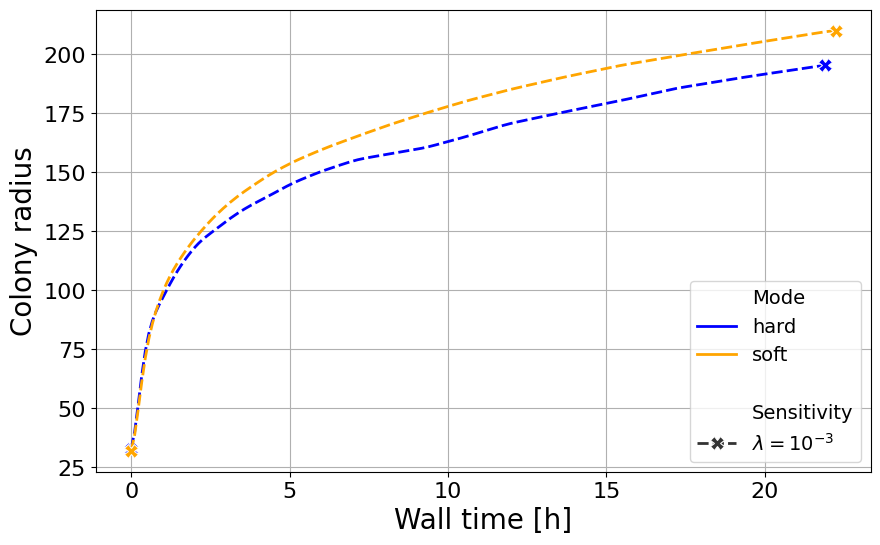

In [109]:
plot_parameter_over_time(sim_dict, "wall_time [h]", "colony_radius",
                         xlabel="Wall time [h]", ylabel="Colony radius", errorbar=("se", 5), outname="huge_wall_time_vs_radius.png");

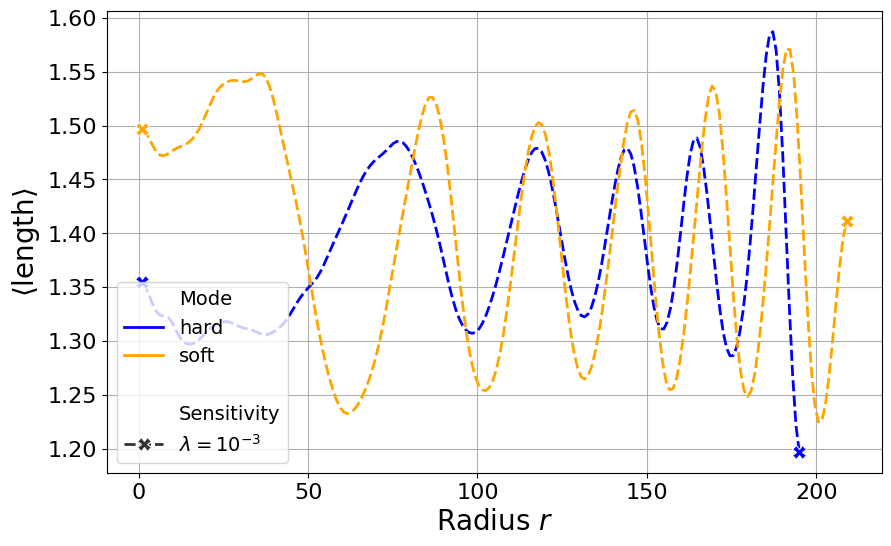

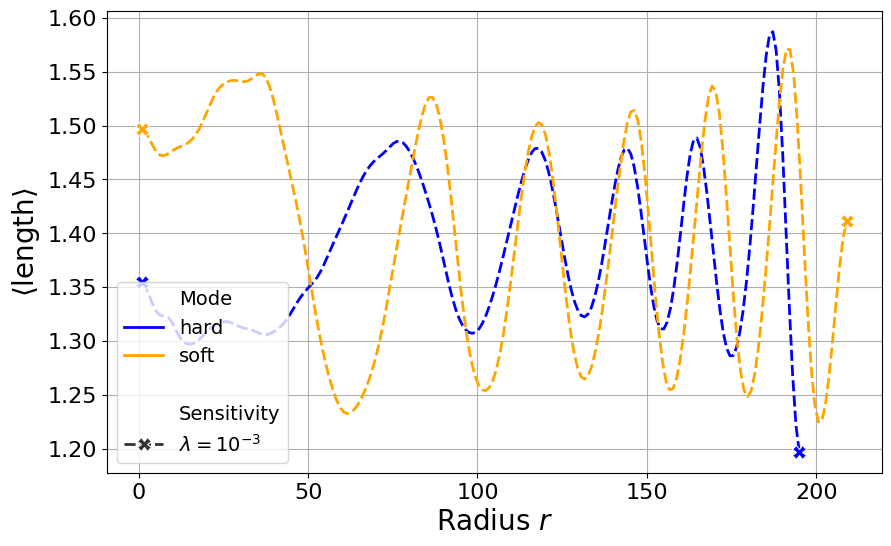

In [108]:
plot_radial_distribution(particles_dict, "length", bin_size, plot_theory=False,
                                xlabel="Radius $r$", ylabel="$\\langle \\text{length} \\rangle$", outname="huge_length_shared.png",   errorbar=("se", 1.2
                                                                                                                                                                     ))

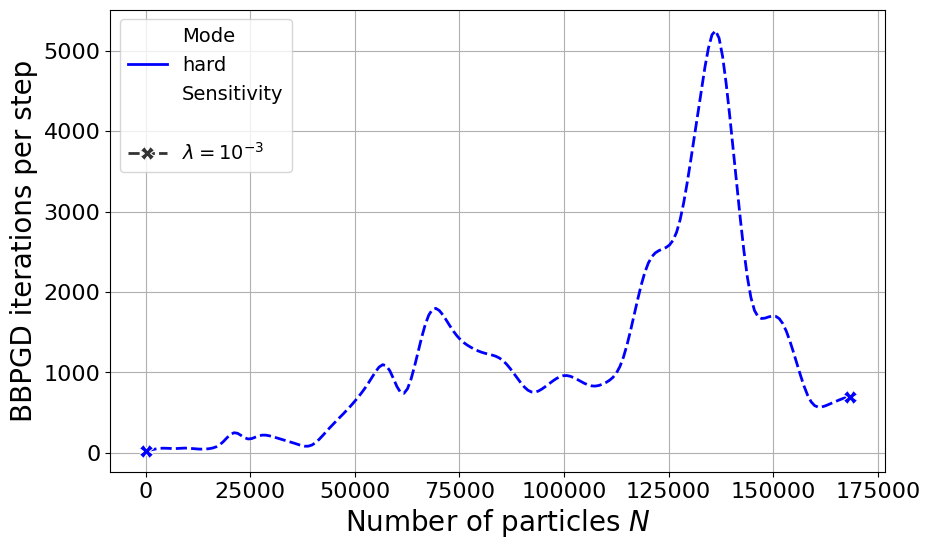

In [142]:
plot_parameter_over_time(sim_dict[sim_dict["Mode"] == "hard"], "num_particles", "bbpgd_iterations_per_step",
                         xlabel="Number of particles $N$", ylabel="BBPGD iterations per step", outname="bbpgd_iterations_per_step_vs_num_particles.png", errorbar=("se", 5));

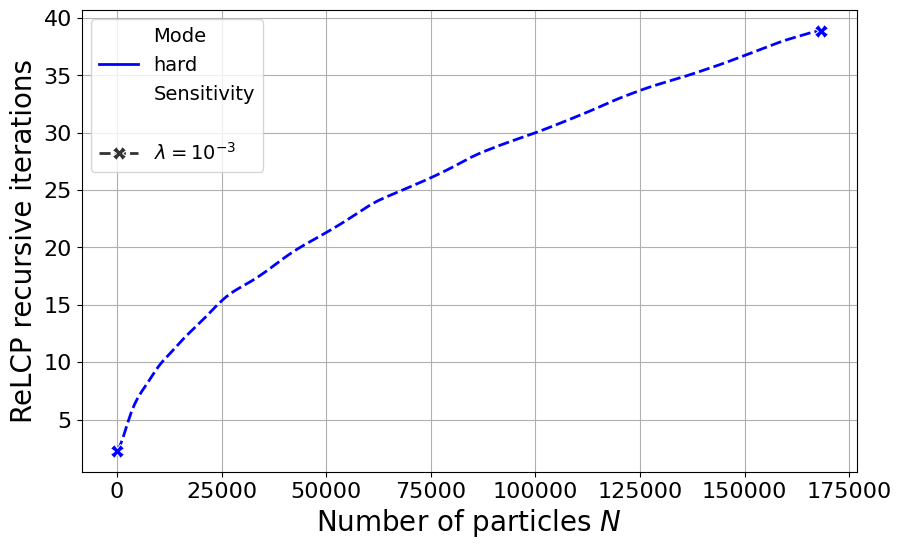

In [150]:
plot_parameter_over_time(sim_dict[sim_dict["Mode"] == "hard"], "num_particles", "iteration",
                         xlabel="Number of particles $N$", ylabel="ReLCP recursive iterations", outname="relcp_recursive_iterations_vs_num_particles.png", errorbar=("se", 5));

In [126]:
sim_dict.keys()

Index(['iteration', 'simulation_time [s]', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'wall_time [s]',
       'wall_time_per_step [s]', 'load_imbalance', 'dt', 'x', 'y', 'z', 'rank',
       'Mode', 'Sensitivity', 'sim_dir', 'offset',
       'wall_time_per_step_particle [s]', 'bbpgd_iterations_per_step',
       'simulation_time [h]', 'wall_time [h]'],
      dtype='object')

In [14]:
sim_dict["bbpgd_iterations_per_step"] = sim_dict["bbpgd_iterations"] / sim_dict["recursive_iterations"]

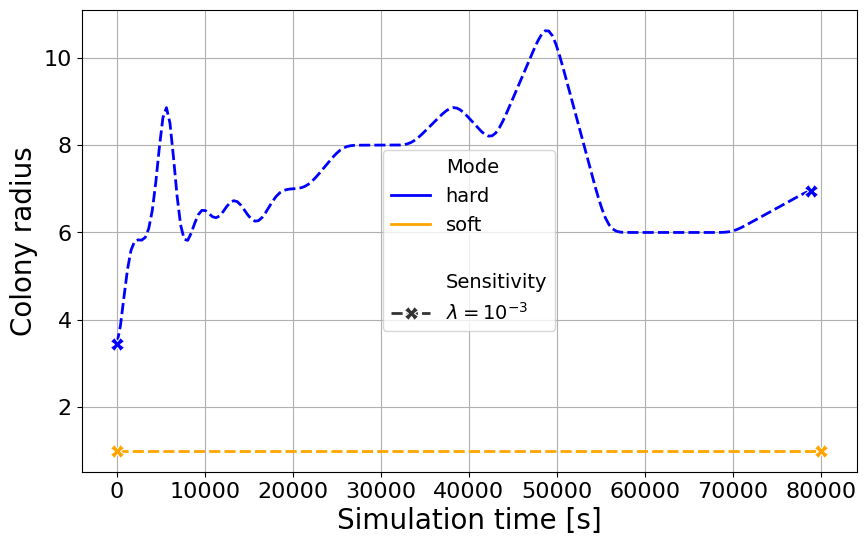

In [153]:
plot_parameter_over_time(sim_dict, "wall_time [s]", "recursive_iterations",
                         xlabel="Simulation time [s]", ylabel="Colony radius", errorbar=("se", 5));

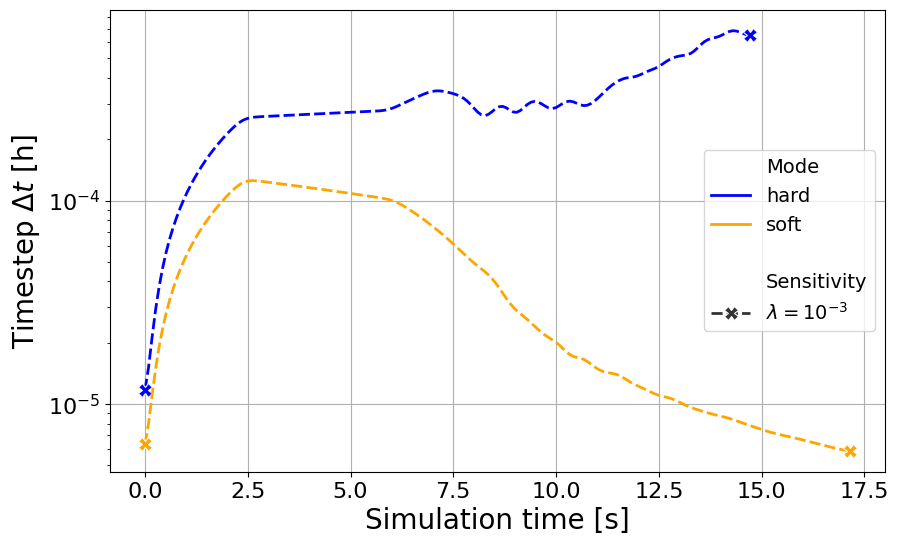

In [151]:
plot_parameter_over_time(sim_dict, "simulation_time [s]", "dt", yscale="log",
                         xlabel="Simulation time [s]", ylabel="Timestep $\\Delta t$ [h]");

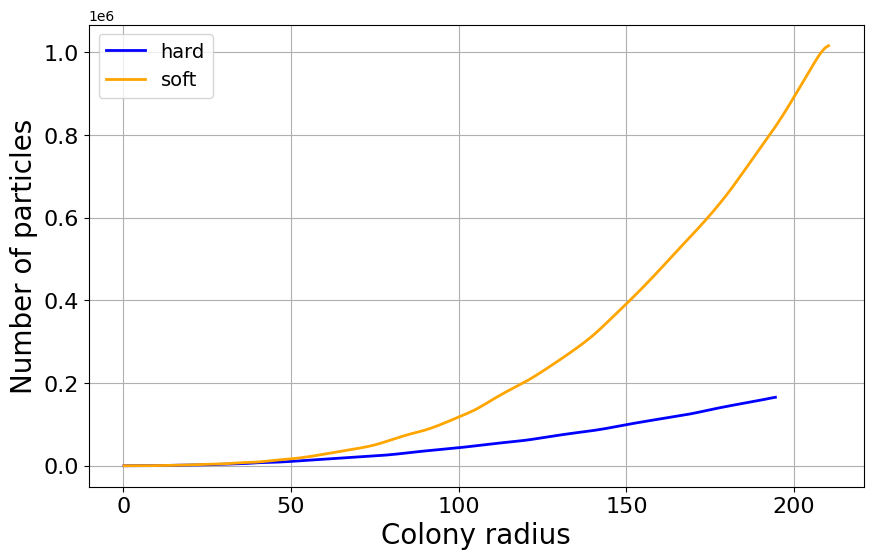

In [17]:
fig = plot_parameter_over_time(sim_dict, "colony_radius", "num_particles",
                                style=None,
                                 xlabel="Colony radius", ylabel="Number of particles");

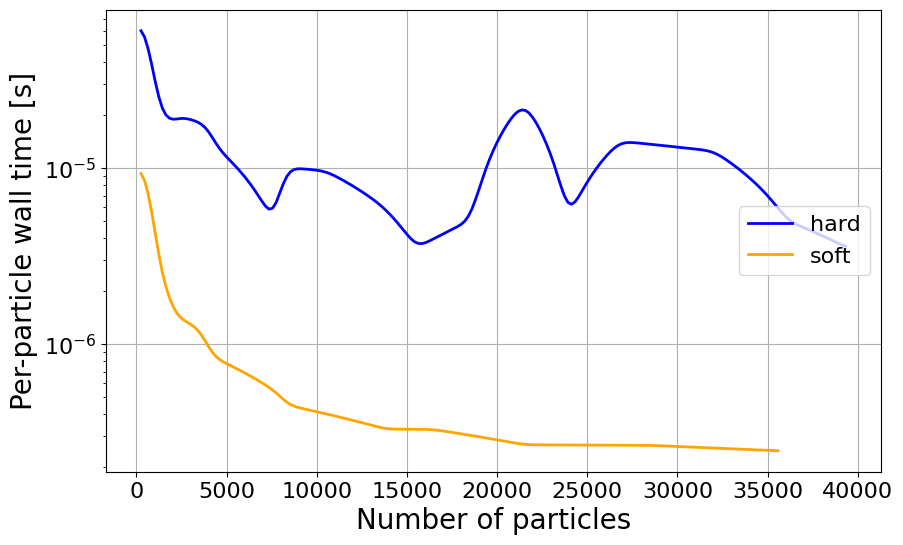

In [18]:
df = sim_dict[(sim_dict["num_particles"] <= 40000) &
              (sim_dict["num_constraints"] >= 150)]
fig = plot_parameter_over_time(df, "num_particles", "wall_time_per_step_particle [s]",
                               yscale="log", style=None,
                               xlabel="Number of particles", ylabel="Per-particle wall time [s]", errorbar=("se", 1))

# move legend center 
fig.gca().legend(loc="center right", fontsize=16)
fig.savefig("combined_num_particles_vs_wall_time_per_particle_with_fit.png",
            dpi=300, bbox_inches="tight")


In [19]:
sim_dict.keys()

Index(['iteration', 'simulation_time [s]', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'wall_time [s]',
       'wall_time_per_step [s]', 'load_imbalance', 'dt', 'x', 'y', 'z', 'rank',
       'Mode', 'Sensitivity', 'sim_dir', 'offset',
       'wall_time_per_step_particle [s]', 'bbpgd_iterations_per_step'],
      dtype='object')

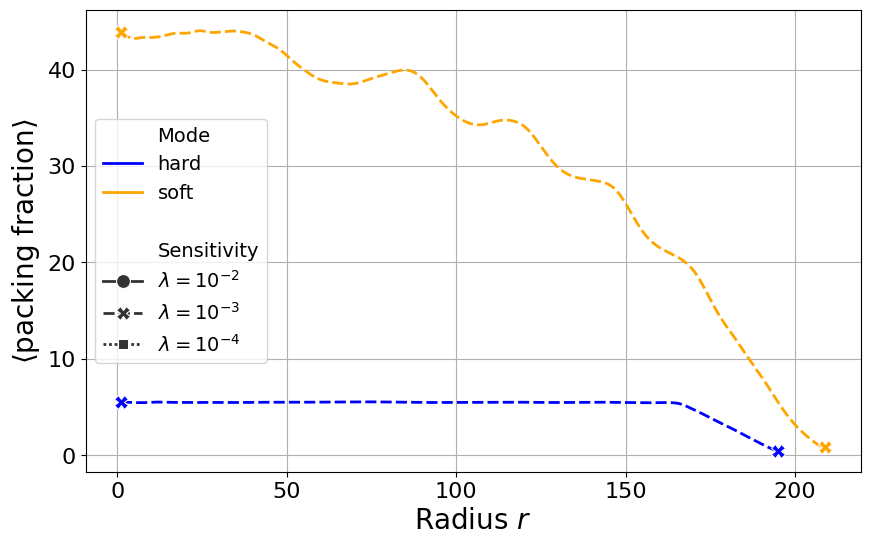

In [39]:
plot_radial_distribution(particles_dict, "packing_fraction", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{packing fraction} \\rangle$", errorbar=("se", 5));

Saving figure to combined_stress_shared.png


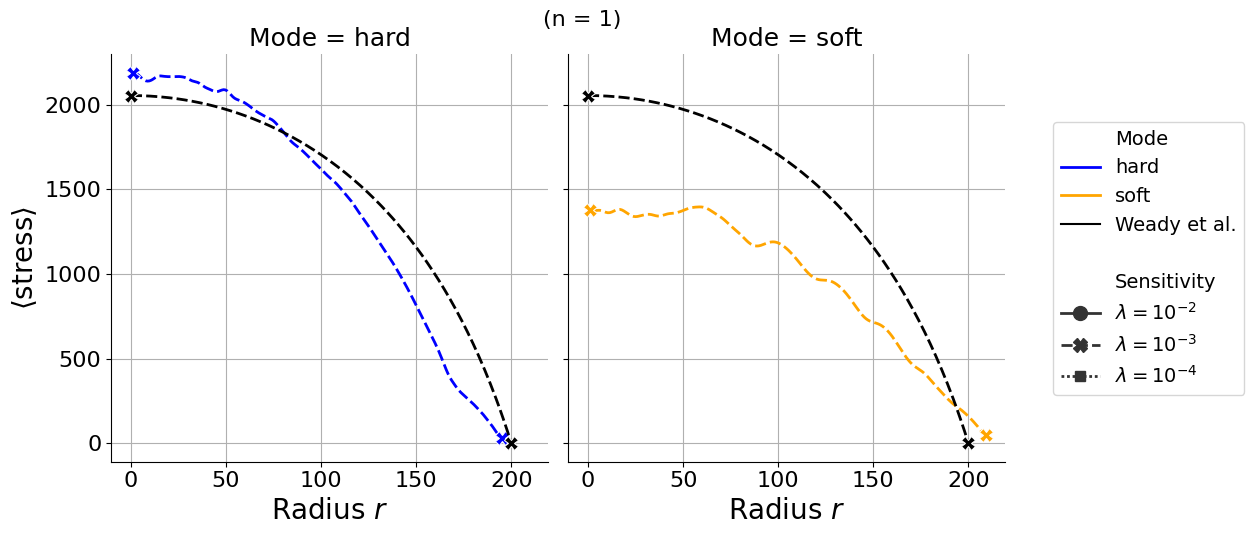

In [46]:



plot_radial_distribution_shared(particles_dict, "stress", bin_size, plot_theory=True,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{stress} \\rangle$", outname="combined_stress_shared.png",   errorbar=("se", 1))

In [22]:
particles_dict["sim_dir"].unique()

array(['huge'], dtype=object)

In [23]:
particles_dict["length"].min()

np.float64(0.980044)

Saving figure to combined_length_shared.png


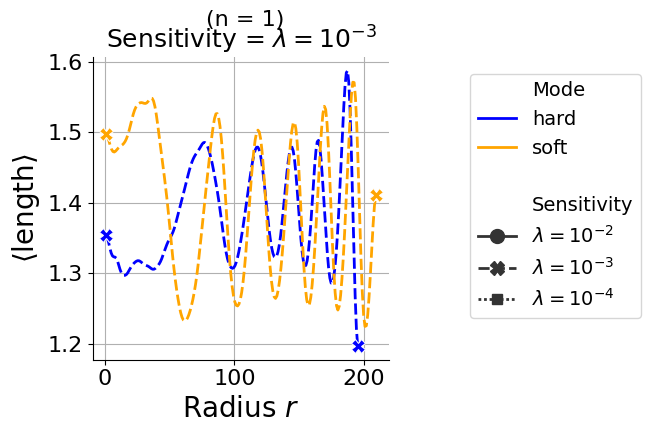

In [25]:
df["bbpgd_iterations"].median()

np.float64(150.0)

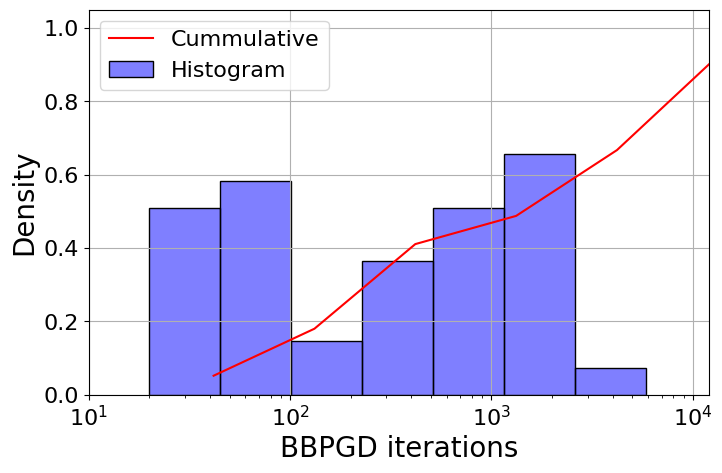

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sim_dict[(sim_dict["Mode"] == "hard")]


# Original histogram
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x="bbpgd_iterations_per_step",
    hue="Mode",
    element="bars",
    stat="density",
    palette=MODE_COLORS,
    log_scale=True,
    line_kws={"linewidth": 5},
    legend=False,

)

sns.histplot(
    data=df,
    x="bbpgd_iterations",
    stat="density",
    cumulative=True,
    element="poly",
    log_scale=True,
    color="red",
    fill=False,
    line_kws={"linewidth": 5},
    legend=False  # don't add a new legend entry
)


# Overlay cumulative distribution as red line

ax = plt.gca()
ax.legend(["Cummulative", "Histogram"], fontsize=16)

# set vllin at median

ax.set_xlim(10, 12000)

ax.set_xlabel("BBPGD iterations", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)

plt.savefig("xcombined_bbpgd_iterations_histogram_cumulative.png",
            dpi=300, bbox_inches="tight")

In [27]:
df["bbpgd_iterations"].mean()

np.float64(5876.25)

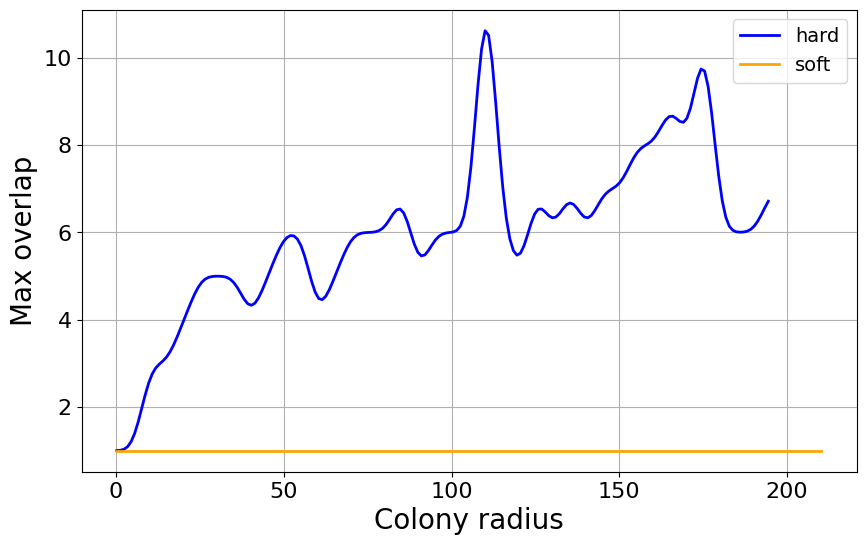

In [28]:
fig = plot_parameter_over_time(sim_dict, "colony_radius", "recursive_iterations",  style=None,
                               xlabel="Colony radius", ylabel="Max overlap", errorbar=("se", 5))
